# Dense And Sparse Correspondence
In this tutorial we show how DINOv3 features can be used to establish correspondences between two objects.

In [1]:
import numpy as np
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm


### Model Loading
We load the DINOv3 ViT-L model. Feel free to try other DINOv3 models as well!

In [ ]:
# examples of available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16" # We use this one
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

# IMPORTANT: PLEASE CLONE THE DINOV3 REPOSITORY LOCALLY AND DOWNLOAD THE WEIGHTS MANUALLY

# we take DINOv3 ViT-L
MODEL_NAME = MODEL_DINOV3_VITL
LOCAL_REPO_PATH = "C:\\Users\\jerem\\Documents\\FDH\\dinov3"
WEIGHT_PATH = "C:\\Users\\jerem\\Documents\\FDH\\dinov3\\dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth" # Needs to be requested from Meta (no automatic download)
    
model = torch.hub.load(
    repo_or_dir=LOCAL_REPO_PATH,
    model=MODEL_NAME,
    source="local",
    weights=WEIGHT_PATH
)
model.cuda()
print(f"Model {MODEL_NAME} loaded successfully.")

Model dinov3_vitl16 loaded successfully.


### Image and Mask loading
Now that we have the model set up, let's load the data. It consists of two image / mask pairs:


In [11]:


image_left_uri = "images/000000217285.jpg"
mask_left_uri = "images/000000217285_mask.jpg"
image_right_uri = "images/000000551215.jpg"
mask_right_uri = "images/000000551215_mask.jpg"

# Load or download images
def load_image_from_url(url: str) -> Image:
    if not url.startswith("http://") and not url.startswith("https://"):
        return Image.open(url)
    else:
        import urllib
        with urllib.request.urlopen(url) as f:
            return Image.open(f)
    

image_left = load_image_from_url(image_left_uri)
mask_left = load_image_from_url(mask_left_uri)

image_right = load_image_from_url(image_right_uri)
mask_right = load_image_from_url(mask_right_uri)

Let's visualize the two images and the corresponding masks:

C:\Users\jerem\AppData\Local\Temp\ipykernel_41540\3126281975.py:34: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_alpha = Image.fromarray(alpha, mode="L")
C:\Users\jerem\AppData\Local\Temp\ipykernel_41540\3126281975.py:35: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_alpha_inv = Image.fromarray(255 - alpha, mode="L")


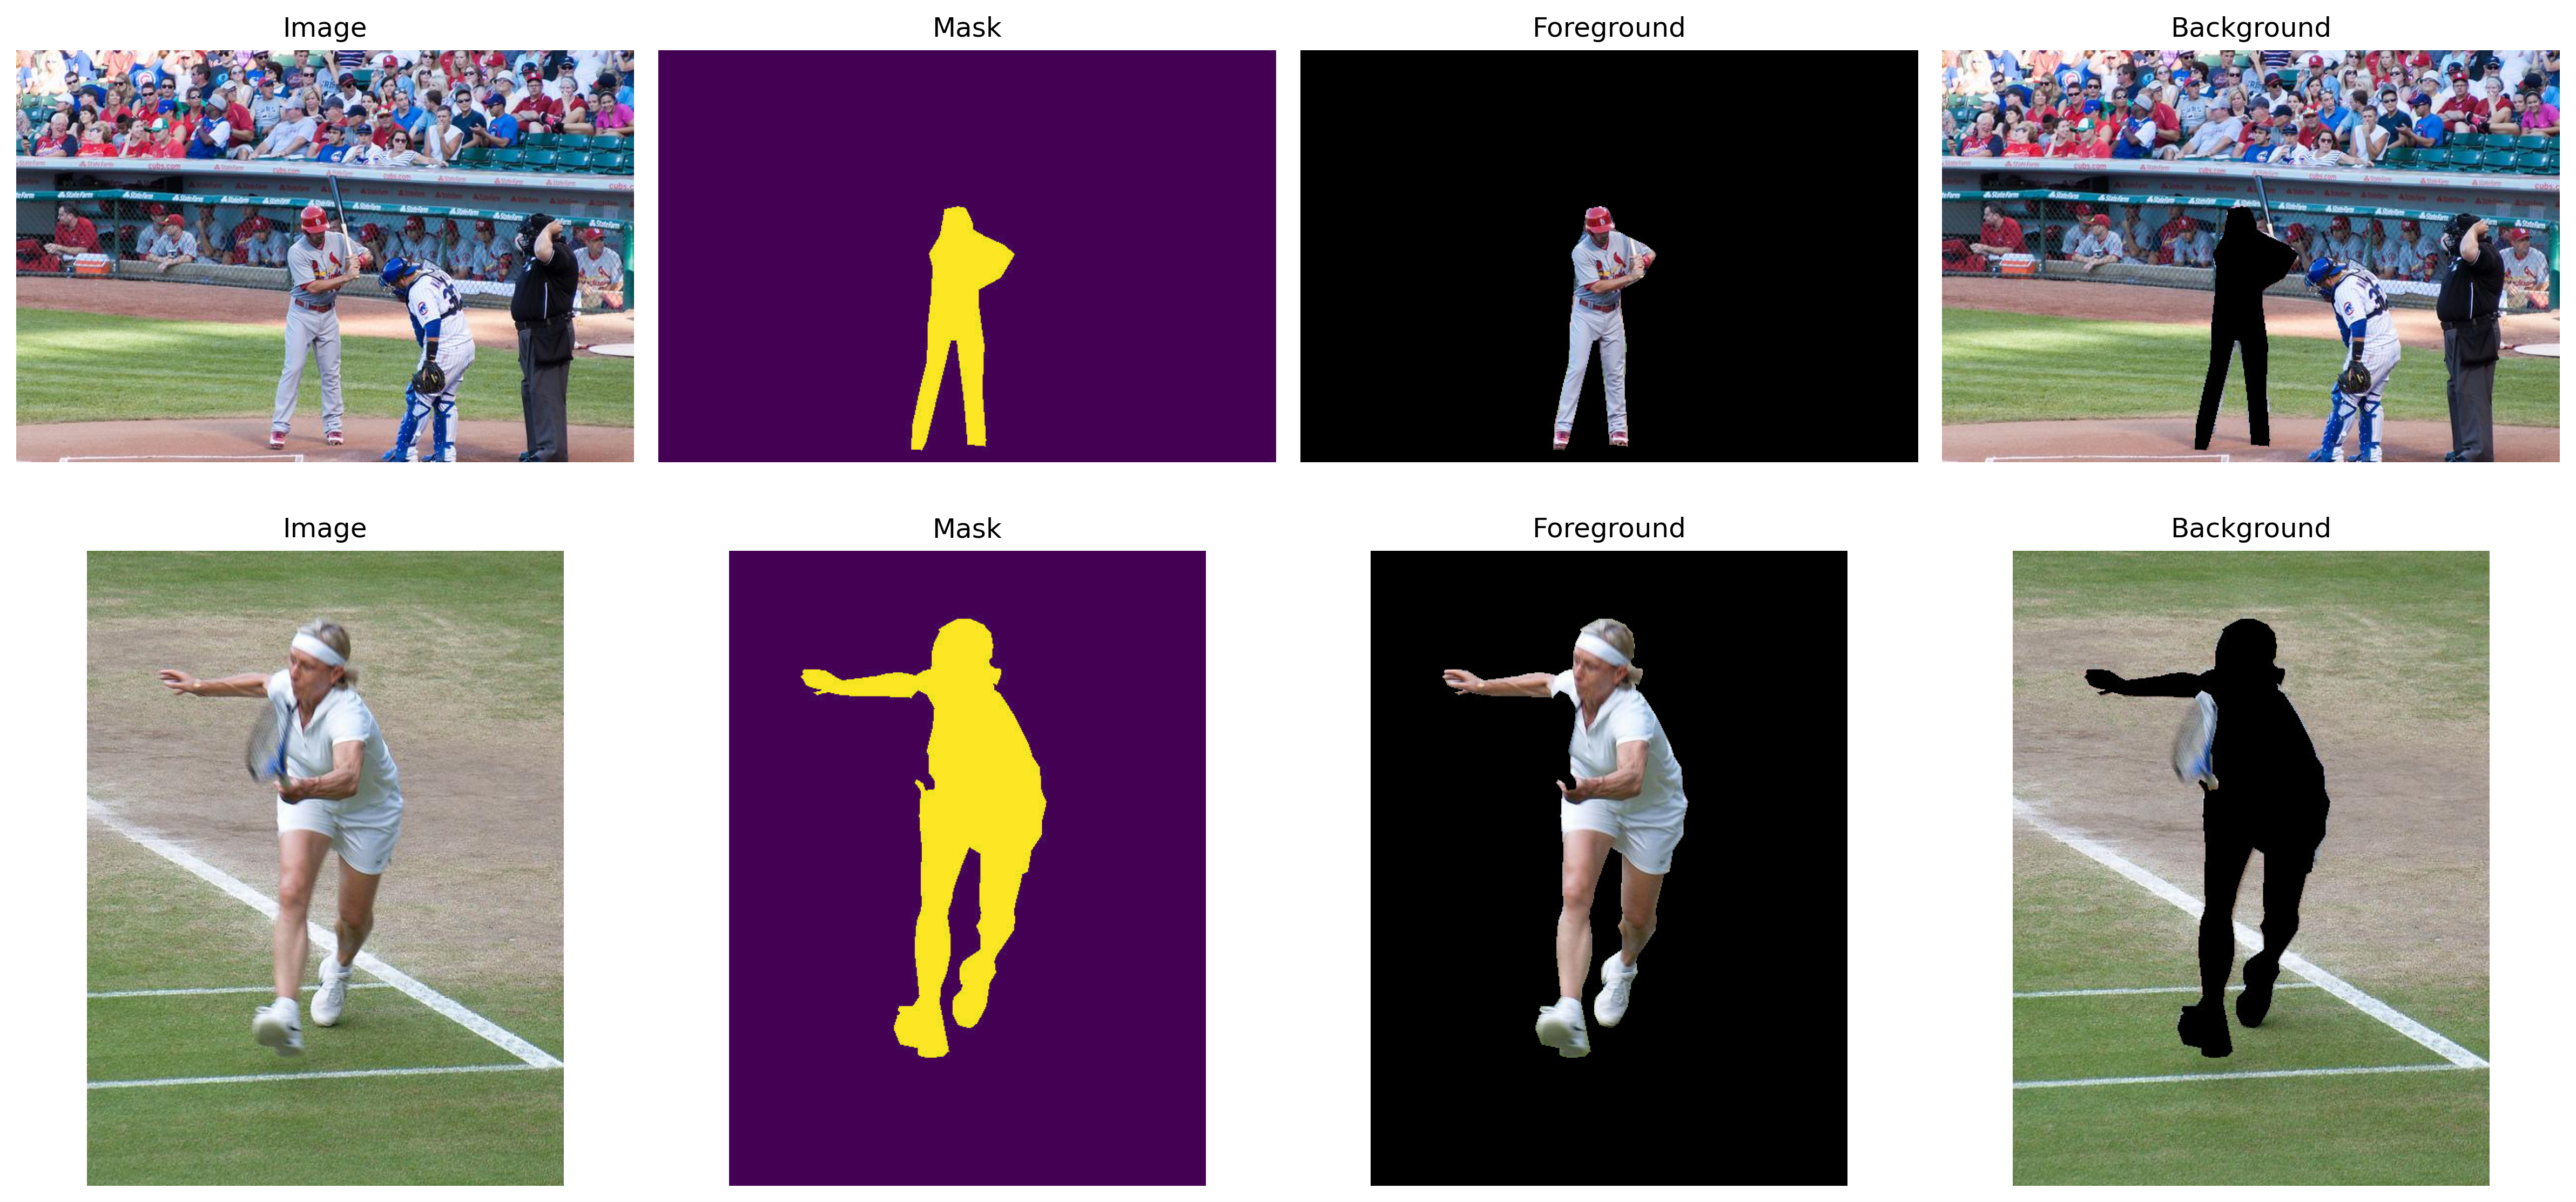

In [ ]:
plt.figure(figsize=(16, 8), dpi=300)

for j, (image, mask) in enumerate([(image_left, mask_left), (image_right, mask_right)]):
    # We needed to convert
    mask_np = np.array(mask)

    if mask_np.ndim == 2:
        # Already single-channel
        alpha = mask_np
    elif mask_np.ndim == 3 and mask_np.shape[2] == 4:
        # RGBA: take alpha channel
        alpha = mask_np[:, :, 3]
    elif mask_np.ndim == 3 and mask_np.shape[2] == 3:
        # RGB: use intensity (any non-zero considered foreground)
        alpha = mask_np.mean(axis=2)
    else:
        raise ValueError(f"Unsupported mask shape: {mask_np.shape}")

    # Normalize to uint8 [0, 255]
    alpha = np.asarray(alpha)

    if alpha.dtype != np.uint8:
        # Scale arbitrary numeric mask to [0, 255]
        max_val = alpha.max() if alpha.max() != 0 else 1
        alpha = (alpha.astype(np.float32) / max_val * 255).astype(np.uint8)
    else:
        # Handle binary 0/1 masks
        max_val = alpha.max()
        if max_val == 1:
            alpha = alpha * 255
        # If max is 0 or 255, we're fine

    # Create PIL 'L' masks
    mask_alpha = Image.fromarray(alpha, mode="L")
    mask_alpha_inv = Image.fromarray(255 - alpha, mode="L")

    # Background color (here black / transparent black)
    if image.mode == "RGBA":
        bg_color = (0, 0, 0, 0)
    elif image.mode == "RGB":
        bg_color = (0, 0, 0)
    else:
        bg_color = 0

    bg = Image.new(image.mode, image.size, bg_color)

    # We use the composite function to apply the alpha mask -> foreground and background
    foreground = Image.composite(image, bg, mask_alpha)
    background = Image.composite(image, bg, mask_alpha_inv)
    
    data_to_show = [image, mask, foreground, background]
    data_labels = ["Image", "Mask", "Foreground", "Background"]

    for i, img in enumerate(data_to_show):
        plt.subplot(2, len(data_to_show), 4 * j + i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(data_labels[i], fontsize=12)

plt.tight_layout()
plt.show()

### Data Transforms

Since our models run with a patch size of 16, we have to quantize the masks to a 16x16 pixels grid. To achieve this, we define:
- the resize transform to resize an image such that it aligns well with the 16x16 grid;
- a uniform 16x16 conv layer as a [box blur filter](https://en.wikipedia.org/wiki/Box_blur) with stride equal to the patch size.

In [5]:
PATCH_SIZE = 16
IMAGE_SIZE = 768

# quantization filter for the given patch size
patch_quant_filter = torch.nn.Conv2d(1, 1, PATCH_SIZE, stride=PATCH_SIZE, bias=False)
patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE))

# image resize transform to dimensions divisible by patch size
def resize_transform(
    mask_image: Image,
    image_size: int = IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    w, h = mask_image.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))

### Extracting Features
Now we will extract for each of the two images mask values, as well as the patch features. That involves running the dense feature extraction with our model using the following code snippet :

```
with torch.inference_mode():        
    feats = model.get_intermediate_layers(img, n=range(n_layers), reshape=True, norm=True)
    patch_features.append(feats[-1].squeeze().detach().cpu())
```
Each tensor of patch features thus has shape `[D, H, W]`, where `D` is feature dimensionality, and `H` and `W` are image dimensions in the number of patches.

In [6]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

patch_mask_values = []
patch_features = []

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        for image, mask in tqdm([(image_left, mask_left), (image_right, mask_right)], desc="Processing images"):
            # processing mask
            mask = mask.split()[-1]
            mask_resized = resize_transform(mask)
            #mask_quantized = patch_quant_filter(mask_resized).squeeze().view(-1).detach().cpu()
            mask_quantized = patch_quant_filter(mask_resized).squeeze().detach().cpu()
            patch_mask_values.append(mask_quantized)
            # processing image
            image = image.convert('RGB')
            image_resized = resize_transform(image)
            image_resized = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
            image_resized = image_resized.unsqueeze(0).cuda()

            feats = model.get_intermediate_layers(image_resized, n=range(n_layers), reshape=True, norm=True)
            dim = feats[-1].shape[1]
            #patch_features.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())
            patch_features.append(feats[-1].squeeze().detach().cpu())

Processing images: 100%|██████████| 2/2 [00:21<00:00, 10.55s/it]


### Matching Patches

For each patch within the foreground object in the left image, we search for the closest patch in the right image using [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between patch features. We select correspondences only for foreground objects.

In [7]:
MASK_FG_THRESHOLD = 0.5

patch_features[0] = F.normalize(patch_features[0], p=2, dim=0)
patch_features[1] = F.normalize(patch_features[1], p=2, dim=0)

heatmaps = torch.einsum(
    "k f, f h w -> k h w",
    patch_features[0].view(dim, -1).permute(1, 0),
    patch_features[1],
)

# compute 2D patch locations in the left image
n_patches_left = patch_features[0].shape[1] * patch_features[0].shape[2]
patch_indices_left = torch.arange(n_patches_left)
locs_2d_left = (
    torch.stack(
        (
            patch_indices_left // patch_features[0].shape[2],  # row
            patch_indices_left % patch_features[0].shape[2]    # column
        ),
        dim=-1
    ) + 0.5
) * PATCH_SIZE

# compute the corresponding 2D patch locations in the right image
patch_indices_right = torch.flatten(heatmaps, start_dim=-2).argmax(dim=-1)
locs_2d_right = (
    torch.stack(
        (
            patch_indices_right // patch_features[1].shape[2],  # row
            patch_indices_right % patch_features[1].shape[2]    # column
        ),
        dim=-1
    ) + 0.5
) * PATCH_SIZE

# foreground patches mask in the left image
patches_left_fg_selection = (patch_mask_values[0].view(-1) > MASK_FG_THRESHOLD)
# left image patches mask for patches that map to a foreground patch in the right image
patches_right_fg_selection = (patch_mask_values[1].view(-1)[patch_indices_right] > MASK_FG_THRESHOLD)
# select foreground left image patches that map to foreground right image patches
patches_fg_selection = (patches_left_fg_selection * patches_right_fg_selection)

# select (row, col) coordinates for the matched patches
locs_2d_left_fg = locs_2d_left[patches_fg_selection, :]
locs_2d_right_fg = locs_2d_right[patches_fg_selection, :]

### Dense Correspondence
We now show dense correspondences between patches using the color space estimated through PCA over foreground patches in the left image. Closer colors correspond to more similar patches.

In [8]:
pca = PCA(n_components=3, whiten=True)
fg_patches_left = patch_features[0].view(dim, -1).permute(1, 0)[patches_fg_selection]
pca.fit(fg_patches_left)

PCA(n_components=3, whiten=True)

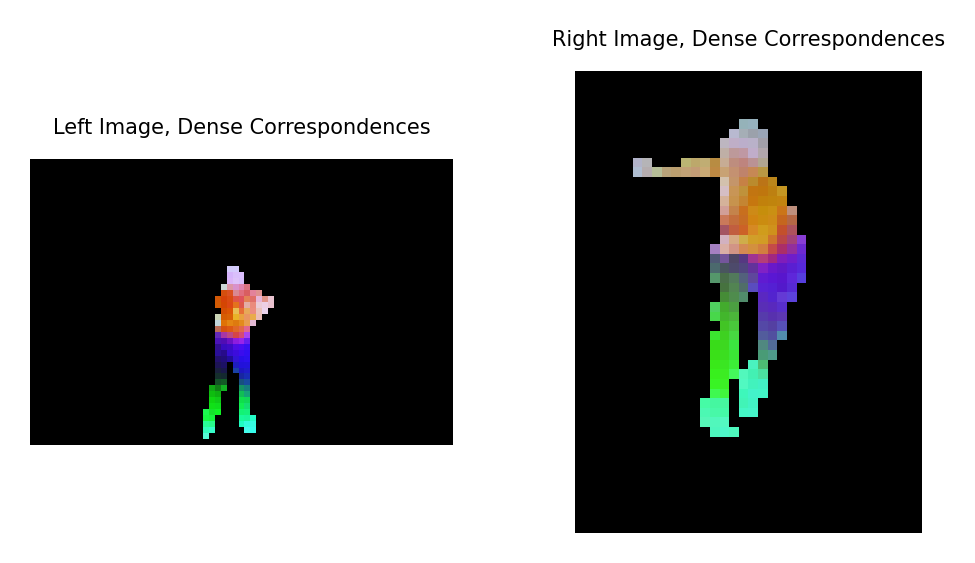

In [9]:
# get colors for the left image
h_patches_left = patch_features[0].shape[1]
w_patches_left = patch_features[0].shape[2]
x_left = patch_features[0].view(dim, -1).permute(1, 0)
projected_image_left = torch.from_numpy(
    pca.transform(x_left.numpy())
).view(h_patches_left, w_patches_left, 3)
# multiply by 2.0 and pass through a sigmoid to get vibrant colors 
projected_image_left = torch.nn.functional.sigmoid(projected_image_left.mul(2.0)).permute(2, 0, 1)

# get colors for the right image
h_patches_right = patch_features[1].shape[1]
w_patches_right = patch_features[1].shape[2]
x_right = patch_features[1].view(dim, -1).permute(1, 0)
projected_image_right = torch.from_numpy(
    pca.transform(x_right.numpy())
).view(h_patches_right, w_patches_right, 3)
projected_image_right = torch.nn.functional.sigmoid(projected_image_right.mul(2.0)).permute(2, 0, 1)

# apply foreground masks to both visualizations
projected_image_left *= (patch_mask_values[0] > MASK_FG_THRESHOLD)[None, :, :]
projected_image_right *= (patch_mask_values[1] > MASK_FG_THRESHOLD)[None, :, :]

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(projected_image_left.permute(1, 2, 0))
plt.title("Left Image, Dense Correspondences", fontsize=5)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(projected_image_right.permute(1, 2, 0))
plt.title("Right Image, Dense Correspondences", fontsize=5)
plt.axis('off')
plt.show()

### Sparse Correspondence

Finally, we show the established correspondences via the sparse set of matched points.

Non-stratified points: (146, 2)
Stratified points: (3, 2)


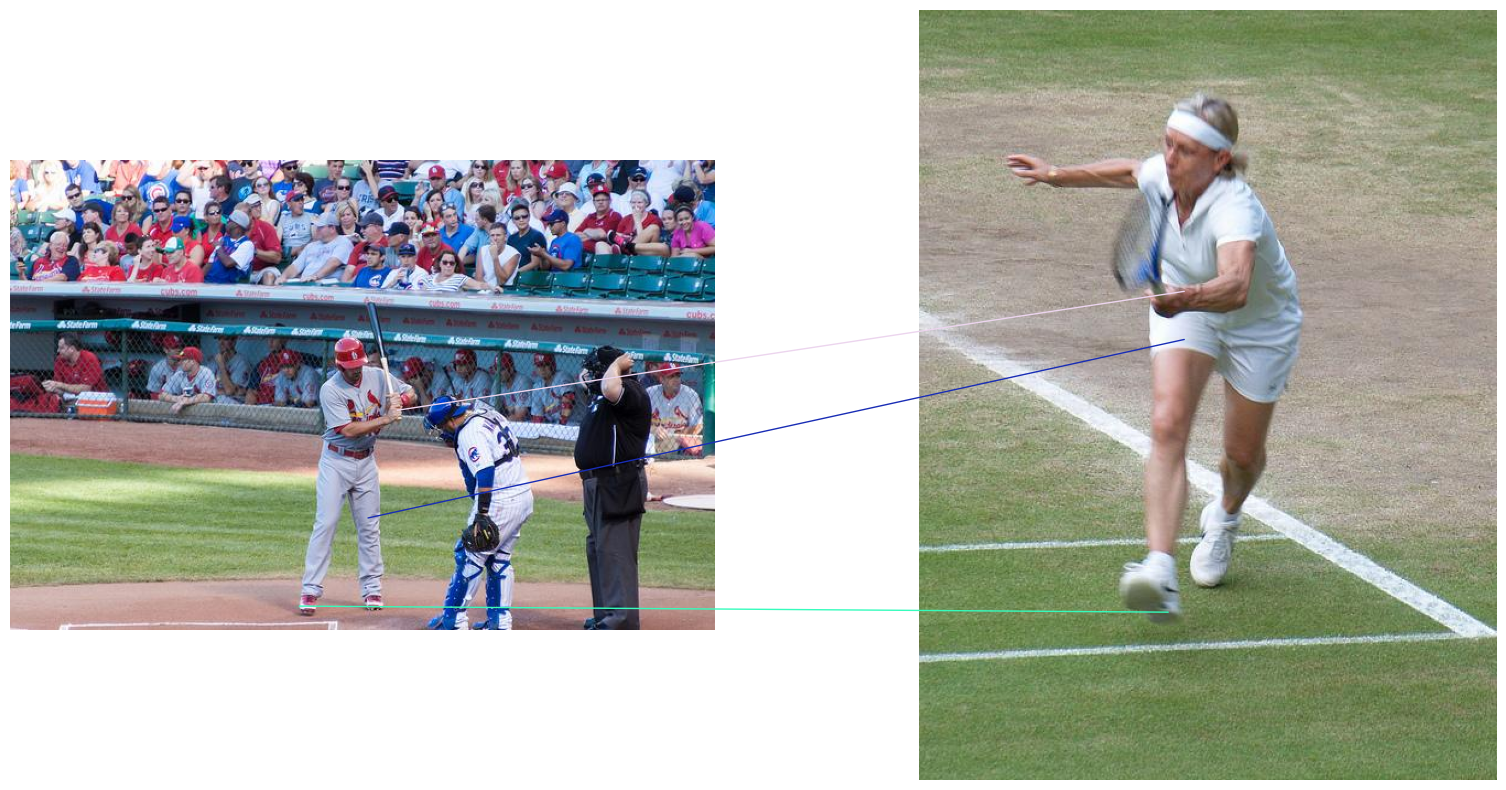

In [10]:
# image scale to go from patches to the original image coordinates
scale_left = image_left.height / IMAGE_SIZE
scale_right = image_right.height / IMAGE_SIZE


STRATIFY_DISTANCE_THRESHOLD = 100.0

def compute_distances_l2(X, Y, X_squared_norm, Y_squared_norm):
    distances = -2 * X @ Y.T
    distances.add_(X_squared_norm[:, None]).add_(Y_squared_norm[None, :])
    return distances


def stratify_points(pts_2d: torch.Tensor, threshold: float = 100.0) -> torch.Tensor:
    # pts_2d: [N, 2]
    n = len(pts_2d)
    max_value = threshold + 1
    pts_2d_sq_norms = torch.linalg.vector_norm(pts_2d, dim=1)
    pts_2d_sq_norms.square_()
    distances = compute_distances_l2(pts_2d, pts_2d, pts_2d_sq_norms, pts_2d_sq_norms)
    distances.fill_diagonal_(max_value)
    distances_mask = torch.empty((n, n), dtype=pts_2d.dtype, device=pts_2d.device)
    torch.le(distances, threshold, out=distances_mask)
    ones_vec = torch.ones(n, device=pts_2d.device, dtype=pts_2d.dtype)
    counts_vec = torch.mv(distances_mask, ones_vec)
    indices_mask = np.ones(n)
    while torch.any(counts_vec).item():
        index_max = torch.argmax(counts_vec).item()
        indices_mask[index_max] = 0
        distances[index_max, :] = max_value
        distances[:, index_max] = max_value
        torch.le(distances, threshold, out=distances_mask)
        torch.mv(distances_mask, ones_vec, out=counts_vec)
    indices_to_exclude = np.nonzero(indices_mask == 0)[0]
    indices_to_keep = np.nonzero(indices_mask > 0)[0]
    return indices_to_exclude, indices_to_keep

print(f"Non-stratified points: {tuple(locs_2d_left_fg.shape)}")

indices_to_exclude, indices_to_keep = stratify_points(locs_2d_left_fg * scale_left, STRATIFY_DISTANCE_THRESHOLD**2)

sparse_points_left_yx = locs_2d_left_fg[indices_to_keep, :].cpu().numpy()
sparse_points_right_yx = locs_2d_right_fg[indices_to_keep, :].cpu().numpy()

print(f"Stratified points: {sparse_points_left_yx.shape}")

# show original left and right images
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.imshow(image_left)
ax1.set_axis_off()
ax2 = fig.add_subplot(122)
ax2.imshow(image_right)
ax2.set_axis_off()


for i, (row_left, col_left), (row_right, col_right) in zip(
    indices_to_keep, sparse_points_left_yx, sparse_points_right_yx
):
    row_left_orig, col_left_orig = locs_2d_left_fg[i]
    # use the color used for PCA visualization
    color = projected_image_left[
        :,
        int(row_left_orig / PATCH_SIZE),
        int(col_left_orig / PATCH_SIZE)
    ].cpu().numpy()
    con = ConnectionPatch(
        xyA=(col_left * scale_left, row_left * scale_left),
        xyB=(col_right * scale_right, row_right * scale_right),
        coordsA="data",
        coordsB="data",
        axesA=ax1,
        axesB=ax2,
        color=color,
    )
    ax2.add_artist(con)